# Project 2: Clustering + SVM: Can We Predict Purchases from Web Sites?
By Shichao Zhou 

# Introduction

In real world, Online retailers often use historical data to try to determine whether or not a given site visitor will actually make a purchase. For this assignment, I will work with the below dataset comprised of a variety of such web site metrics.
Data source is from https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

Steps explanation:
- Data set and attribute information
- Exploratory Data Analysis
- Data Preparation
  - Implement interaction features
  - MinMax Scale for numerical data
  - Get dummy categorical data
- Cluster Modeling 
  - Dendrogram
  - elbow 
  - silhouette plots
- Post-Clustering Exploratory Data Analysis
- Clustering Output vs. Actual Labels  
- SVM Modeling
  - Model1 
  - Model2
  - Model3
- Select Models 
- Clustering + SVM Output vs. Actual Labels
- Conclusion
- Reference

# Data Set and Attribute Information

__Data set information__:The dataset consists of feature vectors belonging to 12,330 sessions.The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

__Attribute information__: 
- The below six values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action. 
 - Administrative: The number of Administrative pages visited by the visitor per session.
 - Administrative_Duration: Time on Administrative pages per session.
 - Informational: The number of Informational pages visited by the visitor per session.
 - Informational_Duration: Time on Informational pages per session.
 - ProductRelated: The number of ProductRelated pages visited by the visitor per session.
 - ProductRelated_Duration: Time on ProductRelated pages per session.
- The below three features represent the metrics measured by "Google Analytics" for each page in the e-commerce site.
 - Bounce Rate: The feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. (Bounce Rate = Single Page Visits / Total Visits)
 - Exit Rate: The feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 
 - Page Value: The feature represents the average value for a web page that a user visited before completing an e-commerce transaction. 
- Special Day: The feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 
- The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

# Pre-Clustering Exploratory Data Analysis


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

In [2]:
# Loading the data set
df=pd.read_csv("https://raw.githubusercontent.com/sczhou0705/DAV-6150-2/main/Project2_Data%20(1).csv")
# Sanity check
df.head(1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.0,0.0,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True


In [3]:
# Check if there is negative value in the columns
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [4]:
# Missing value checking and data type checking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
# Check unique for each columns
df.nunique()

Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
dtype: int64

In [6]:
df_num = df.iloc[:,0:10]
df_num

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,0,0.00,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0
1,0,0.00,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0
2,4,37.50,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0
3,4,115.70,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0
4,1,60.00,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
12325,3,148.00,0,0.0,8,292.500000,0.000000,0.027273,0.000000,0.0
12326,1,9.00,1,29.5,23,1157.583333,0.007692,0.053846,0.000000,0.0
12327,0,0.00,0,0.0,91,4157.633333,0.010000,0.028013,0.000000,0.0
12328,0,0.00,0,0.0,38,1417.666667,0.016117,0.048718,0.000000,1.0


EDA of Numerical data

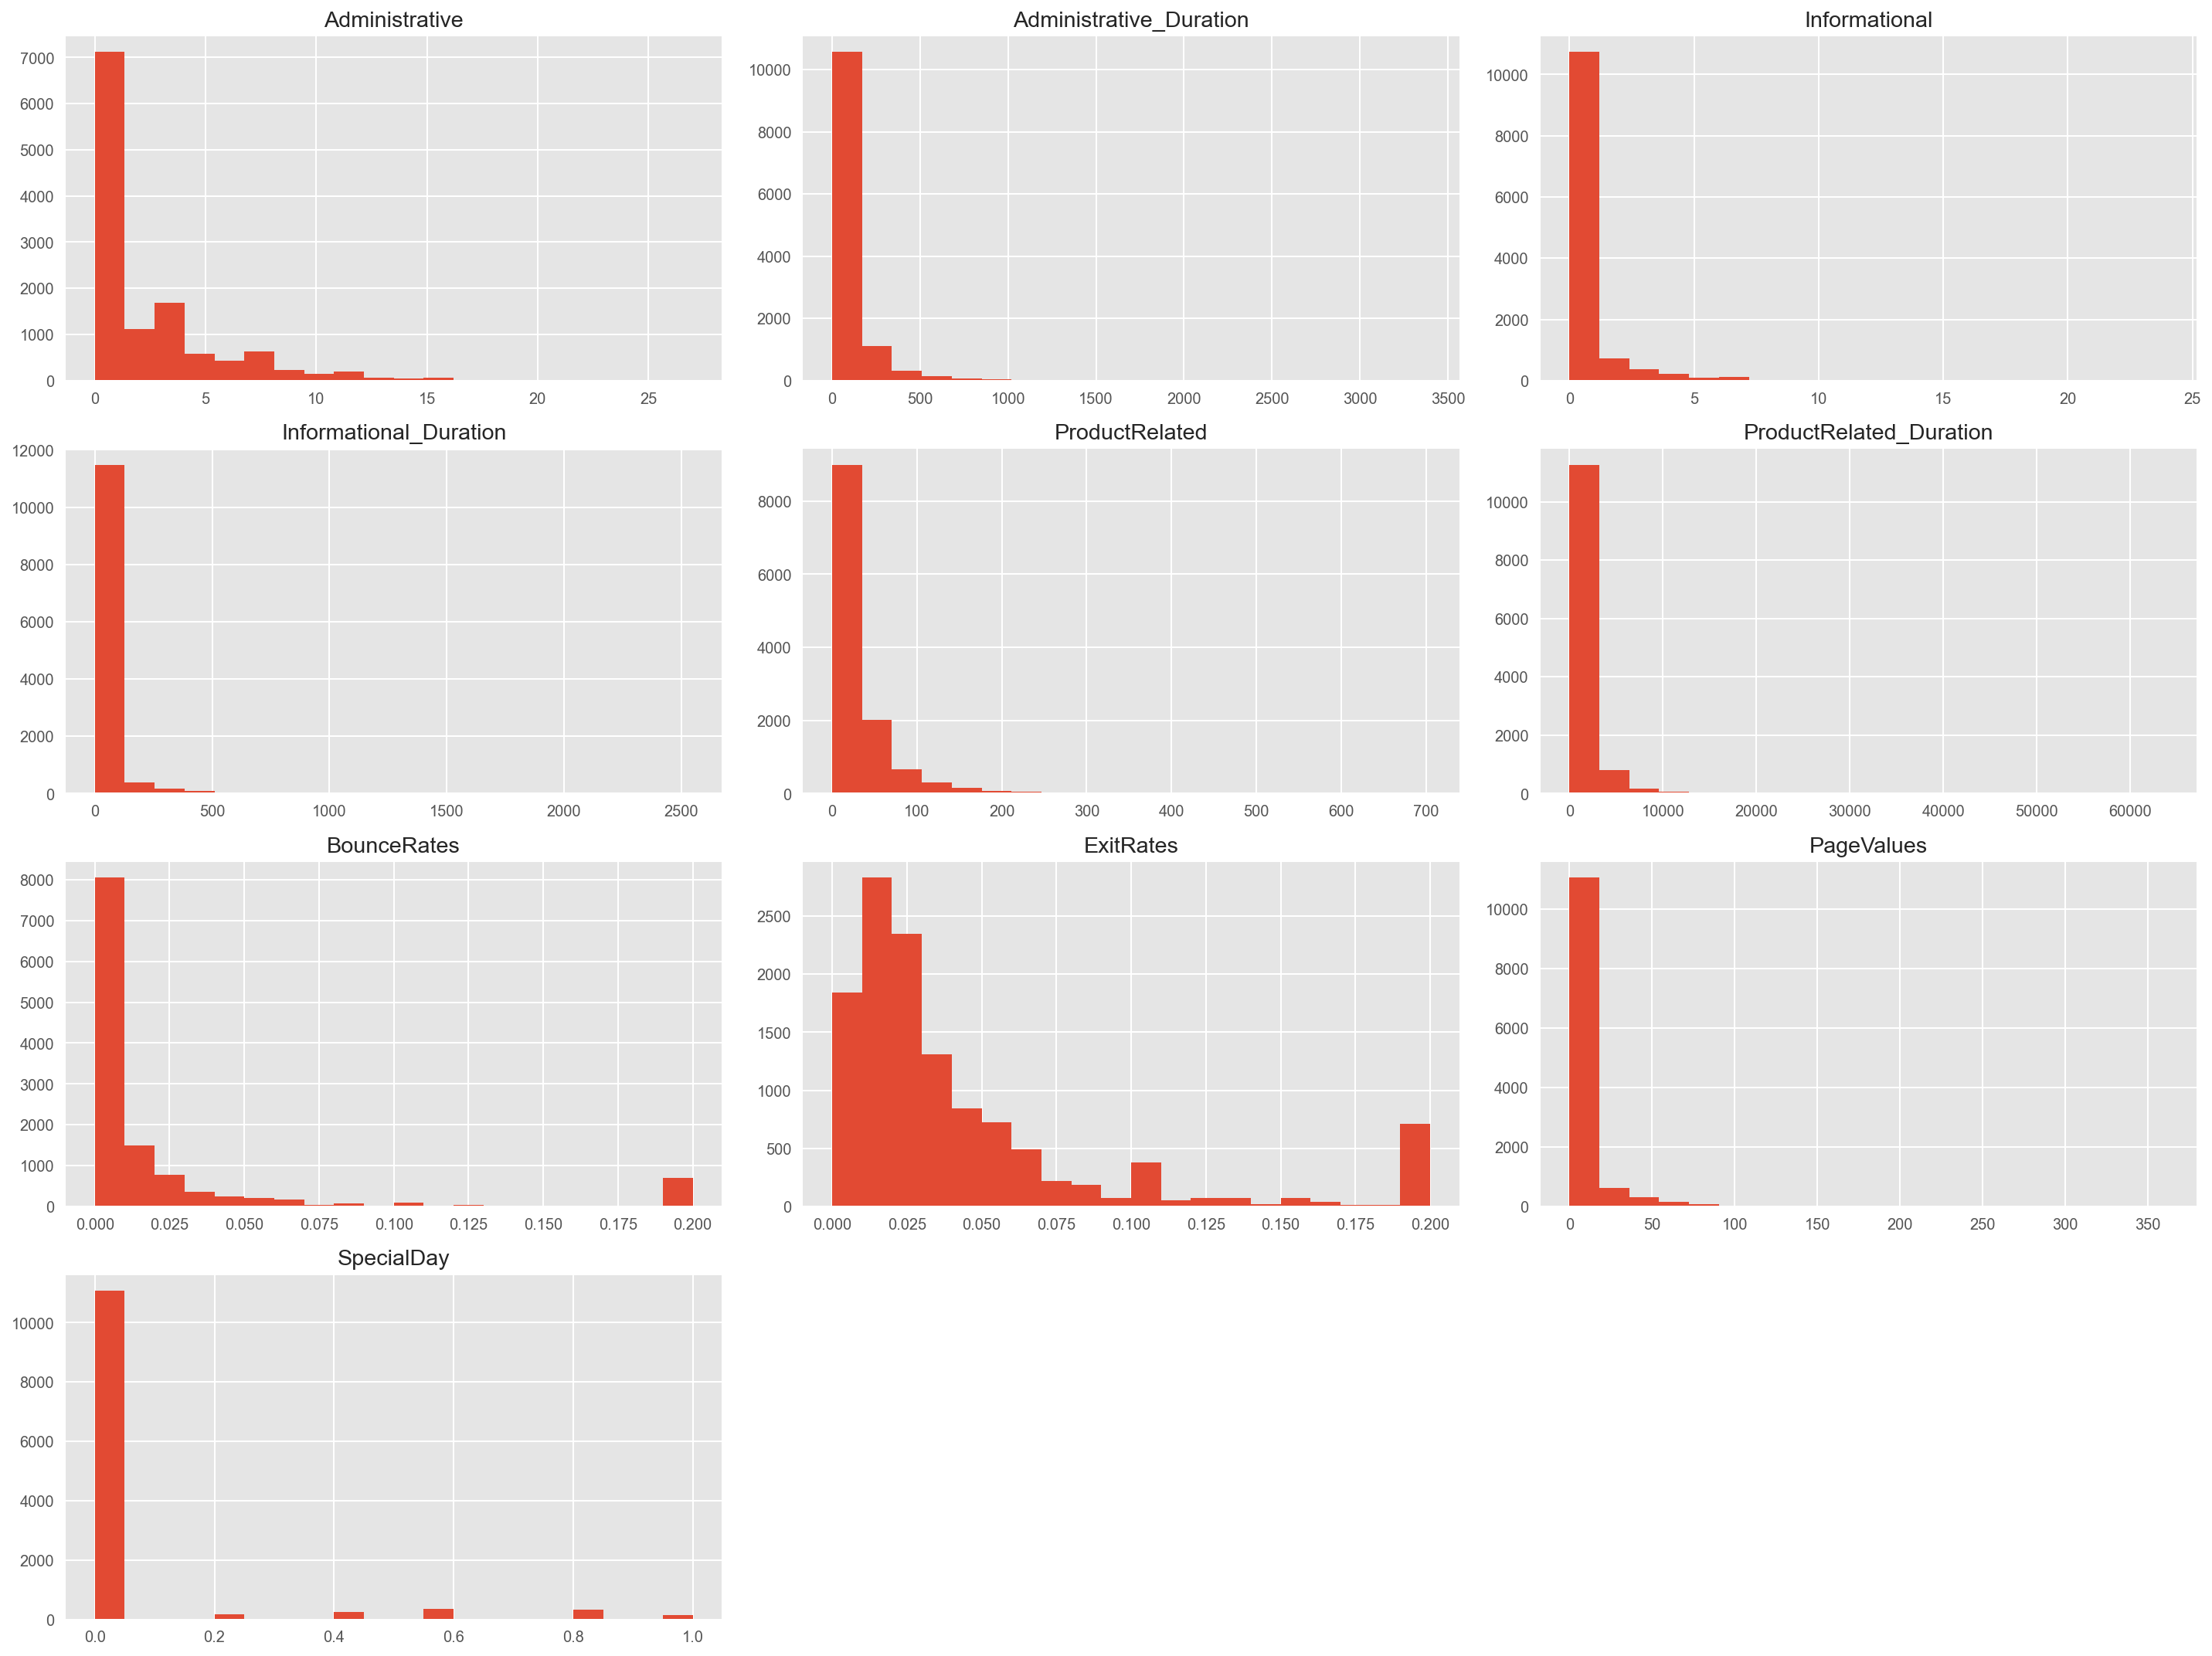

In [7]:
# Distribution of numerical data
df_num.hist(bins=20, figsize=(20,15))
plt.grid()
plt.tight_layout()

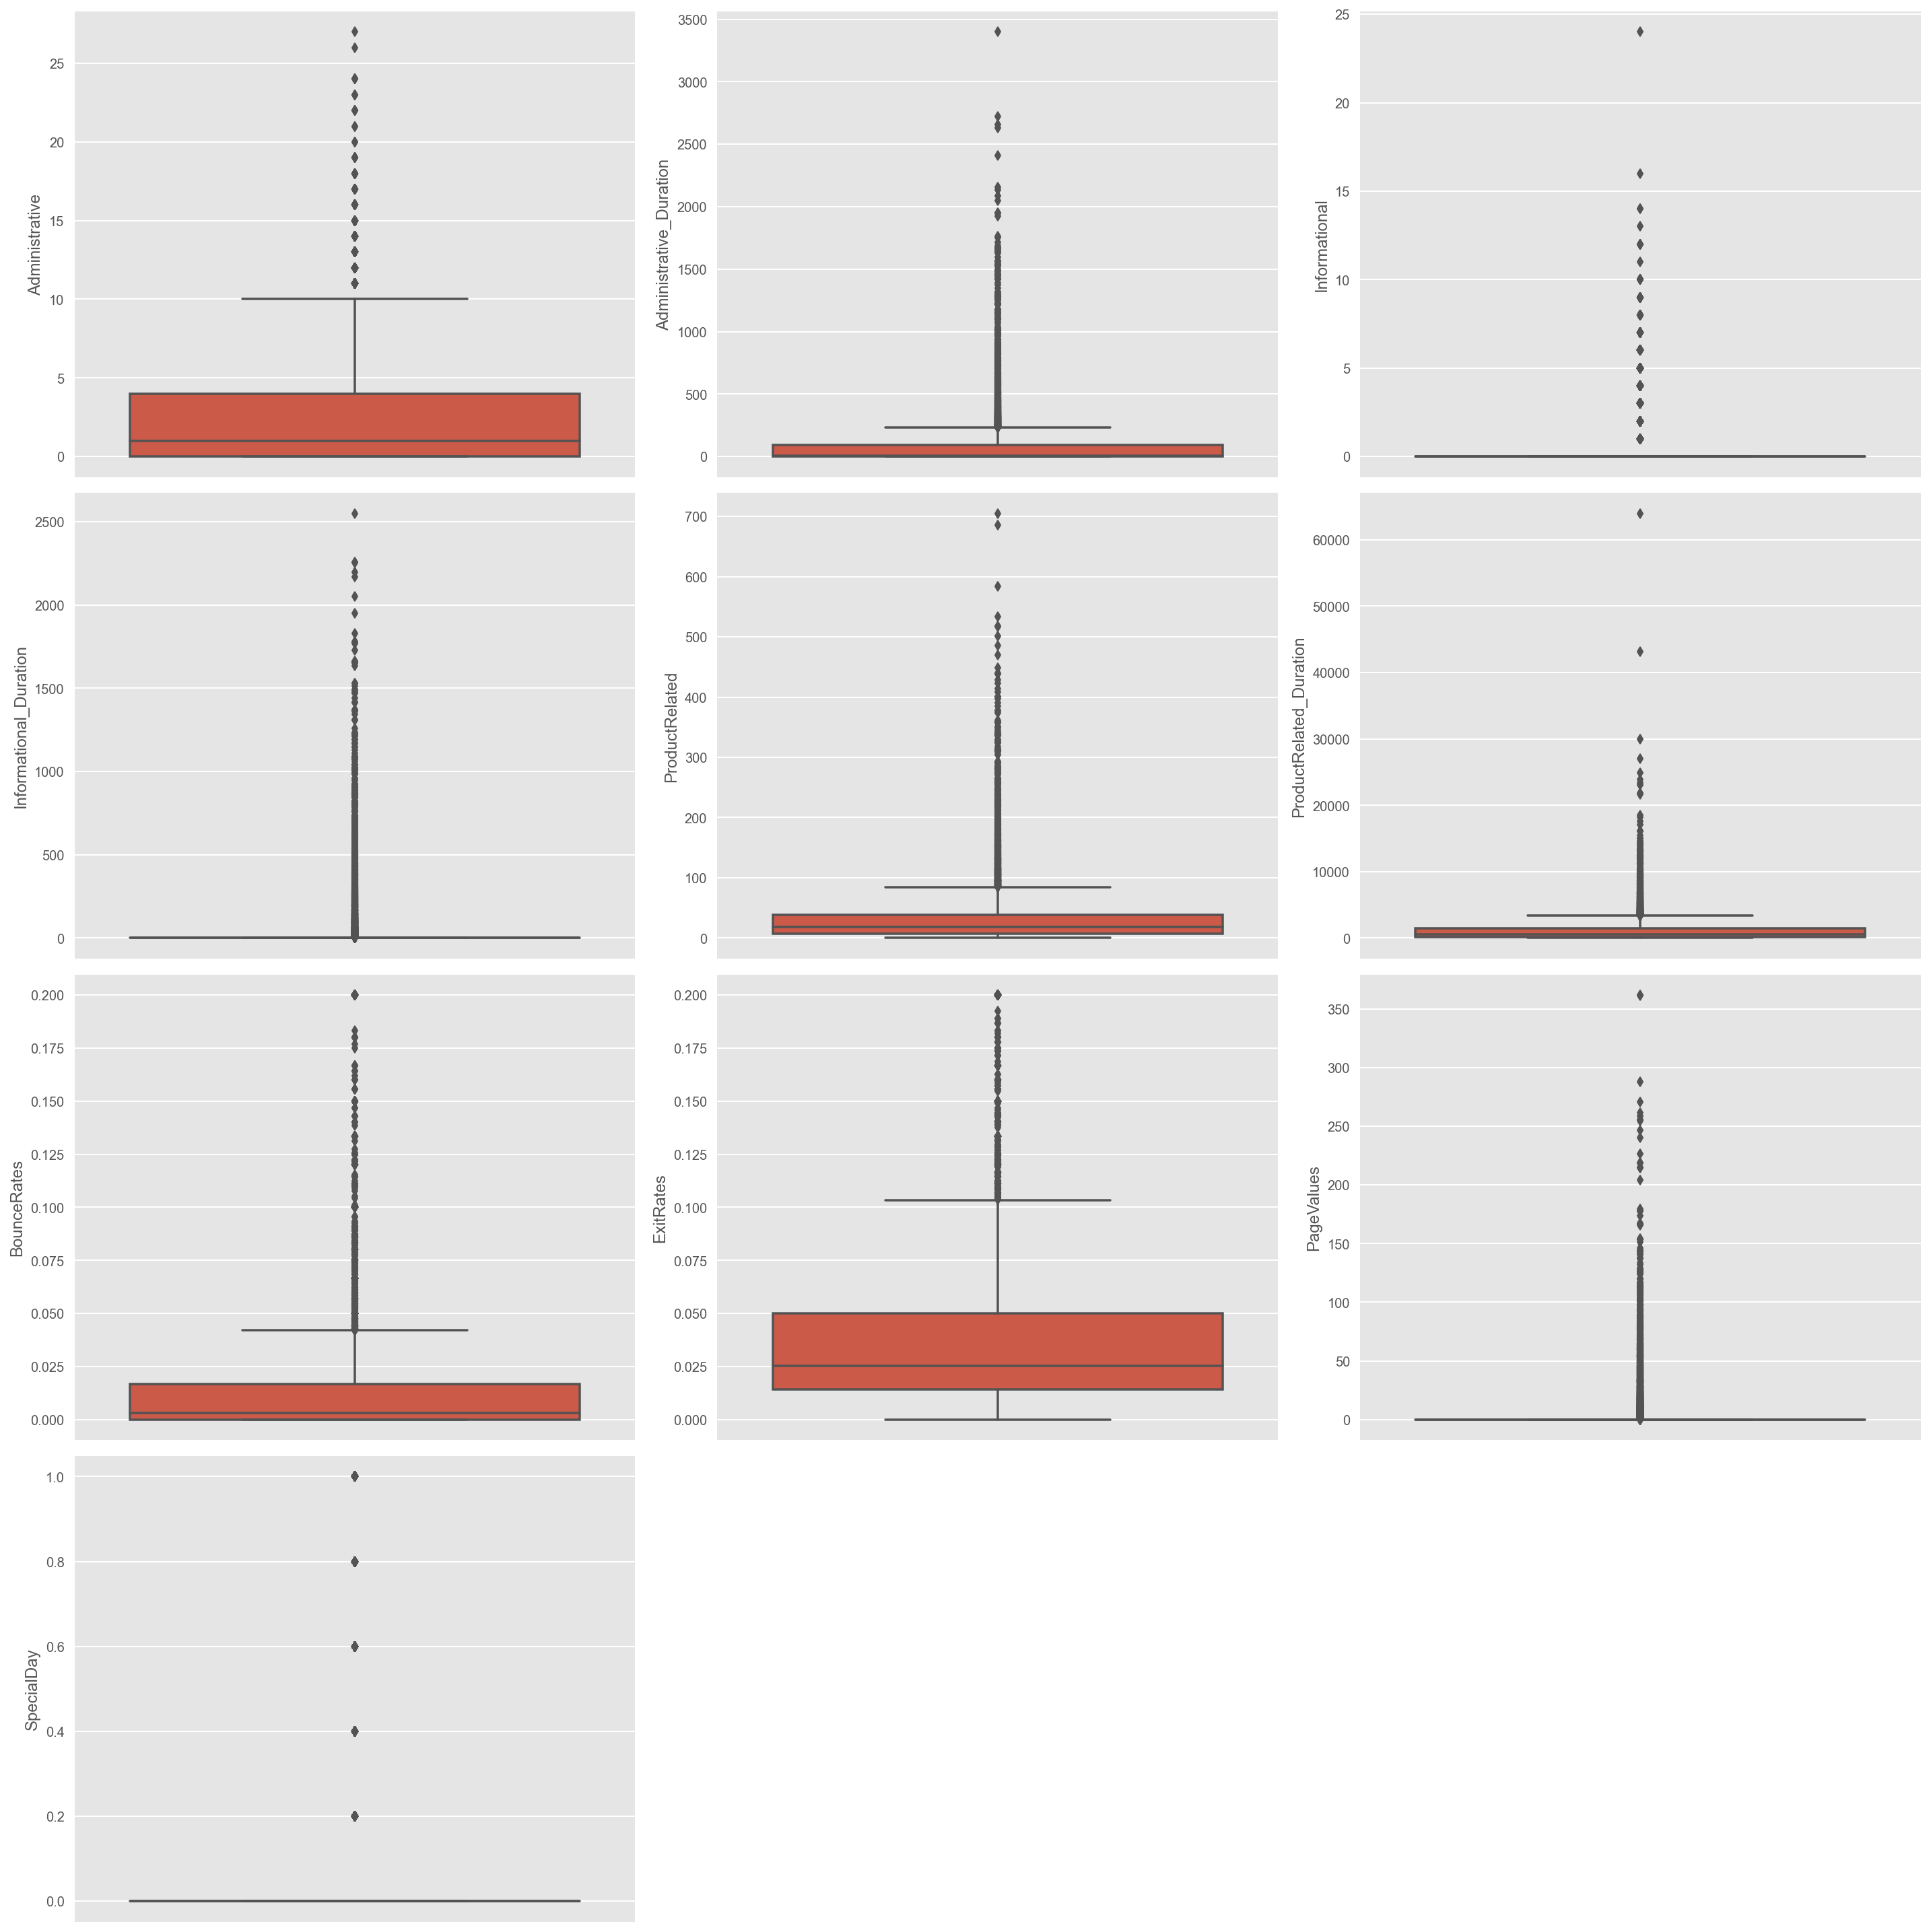

In [8]:
# Create boxplots for numerical data.
plt.figure(figsize = (20, 25))
for i, col in enumerate(df_num):
    plt.subplot(5,3, i + 1)
    sns.boxplot(data=df_num,y=col,orient="v")
    plt.tight_layout()

- All the numerical attributes are right-skewed.
- The numerical attributes have outliers. I will not remove the outliers because they are valid data. The ranges of bounce rate and exit rates are from 0-1. No outliers exceed the 0-1 range. While a high bounce rate usually signals problems with user satisfaction – whether it be in context of content, site quality, loading speed, etc. – a high exit rate usually signals problems in your conversion funnel. (https://cxl.com/guides/bounce-rate/bounce-rate-vs-exit-rate/) Also, the situation of durations over thousands appears in the real world, so these outliers can be considered valid data. 
- Except bounce rate and exit rate, these attributes are in different scales. So in the data preparation, I will use the Minmaxscaler method to scale the data in the same range.

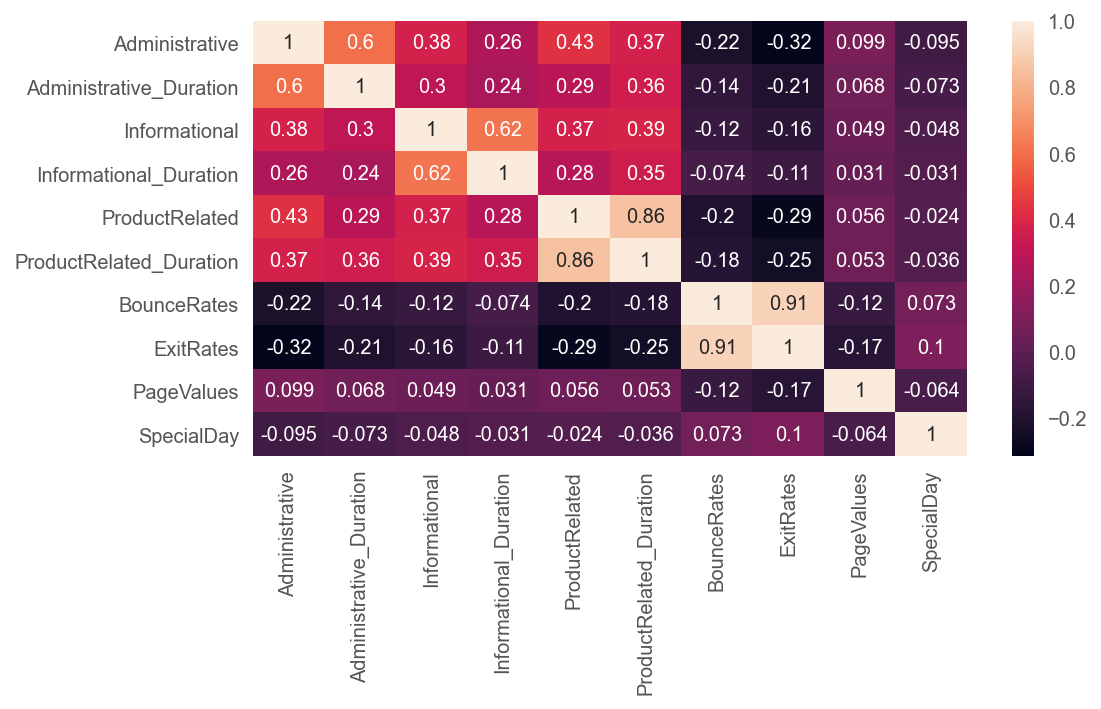

In [9]:
# Correlation of numerical data
corr = df_num.corr()
plt.figure()
sns.heatmap(corr,annot = True)
plt.show()

- The coefficient of Administrative_Duration and Administrative is 0.6, representing the two attributes are medium correlated; The coefficient of information_duration and information is 0.62, meaning the two attributes are medium correlated; The coefficient of productRelated_Duration and ProductRelated is 0.86, representing the two attributes are highly correlated. Based on the data attributes explanations, I will use feature interaction (quotient) in data preparation to reduce the six attributes to three attributes.
- Bounce rate and exit rates are highly correlated because their coefficient is over 0.9. But I will not remove one of the attributes. The reason is that they are all necessary metrics to measure page quality. The size of the Bounce Rate indicates the quality of the Landing Page (entry page) of the website. The size of the Exit Rate directly means the quality of the content of each page.
- The strength of the relationship between Page value and other attributes is feeble.
- The strength of the relationship between special day and other attributes is feeble.

EDA of Categorical data

In [10]:
# Distribution of categorical data
df_cat = df.iloc[:,10:17]
df_cat

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,May,1,1,1,2,New_Visitor,True
1,Mar,2,2,4,2,Returning_Visitor,False
2,Nov,2,2,9,2,New_Visitor,False
3,Nov,1,1,2,3,Returning_Visitor,False
4,May,2,2,3,4,Returning_Visitor,False
...,...,...,...,...,...,...,...
12325,Mar,2,2,1,3,Returning_Visitor,True
12326,Nov,2,2,7,2,Returning_Visitor,False
12327,Jul,2,2,1,13,Returning_Visitor,False
12328,May,2,6,3,6,Returning_Visitor,True


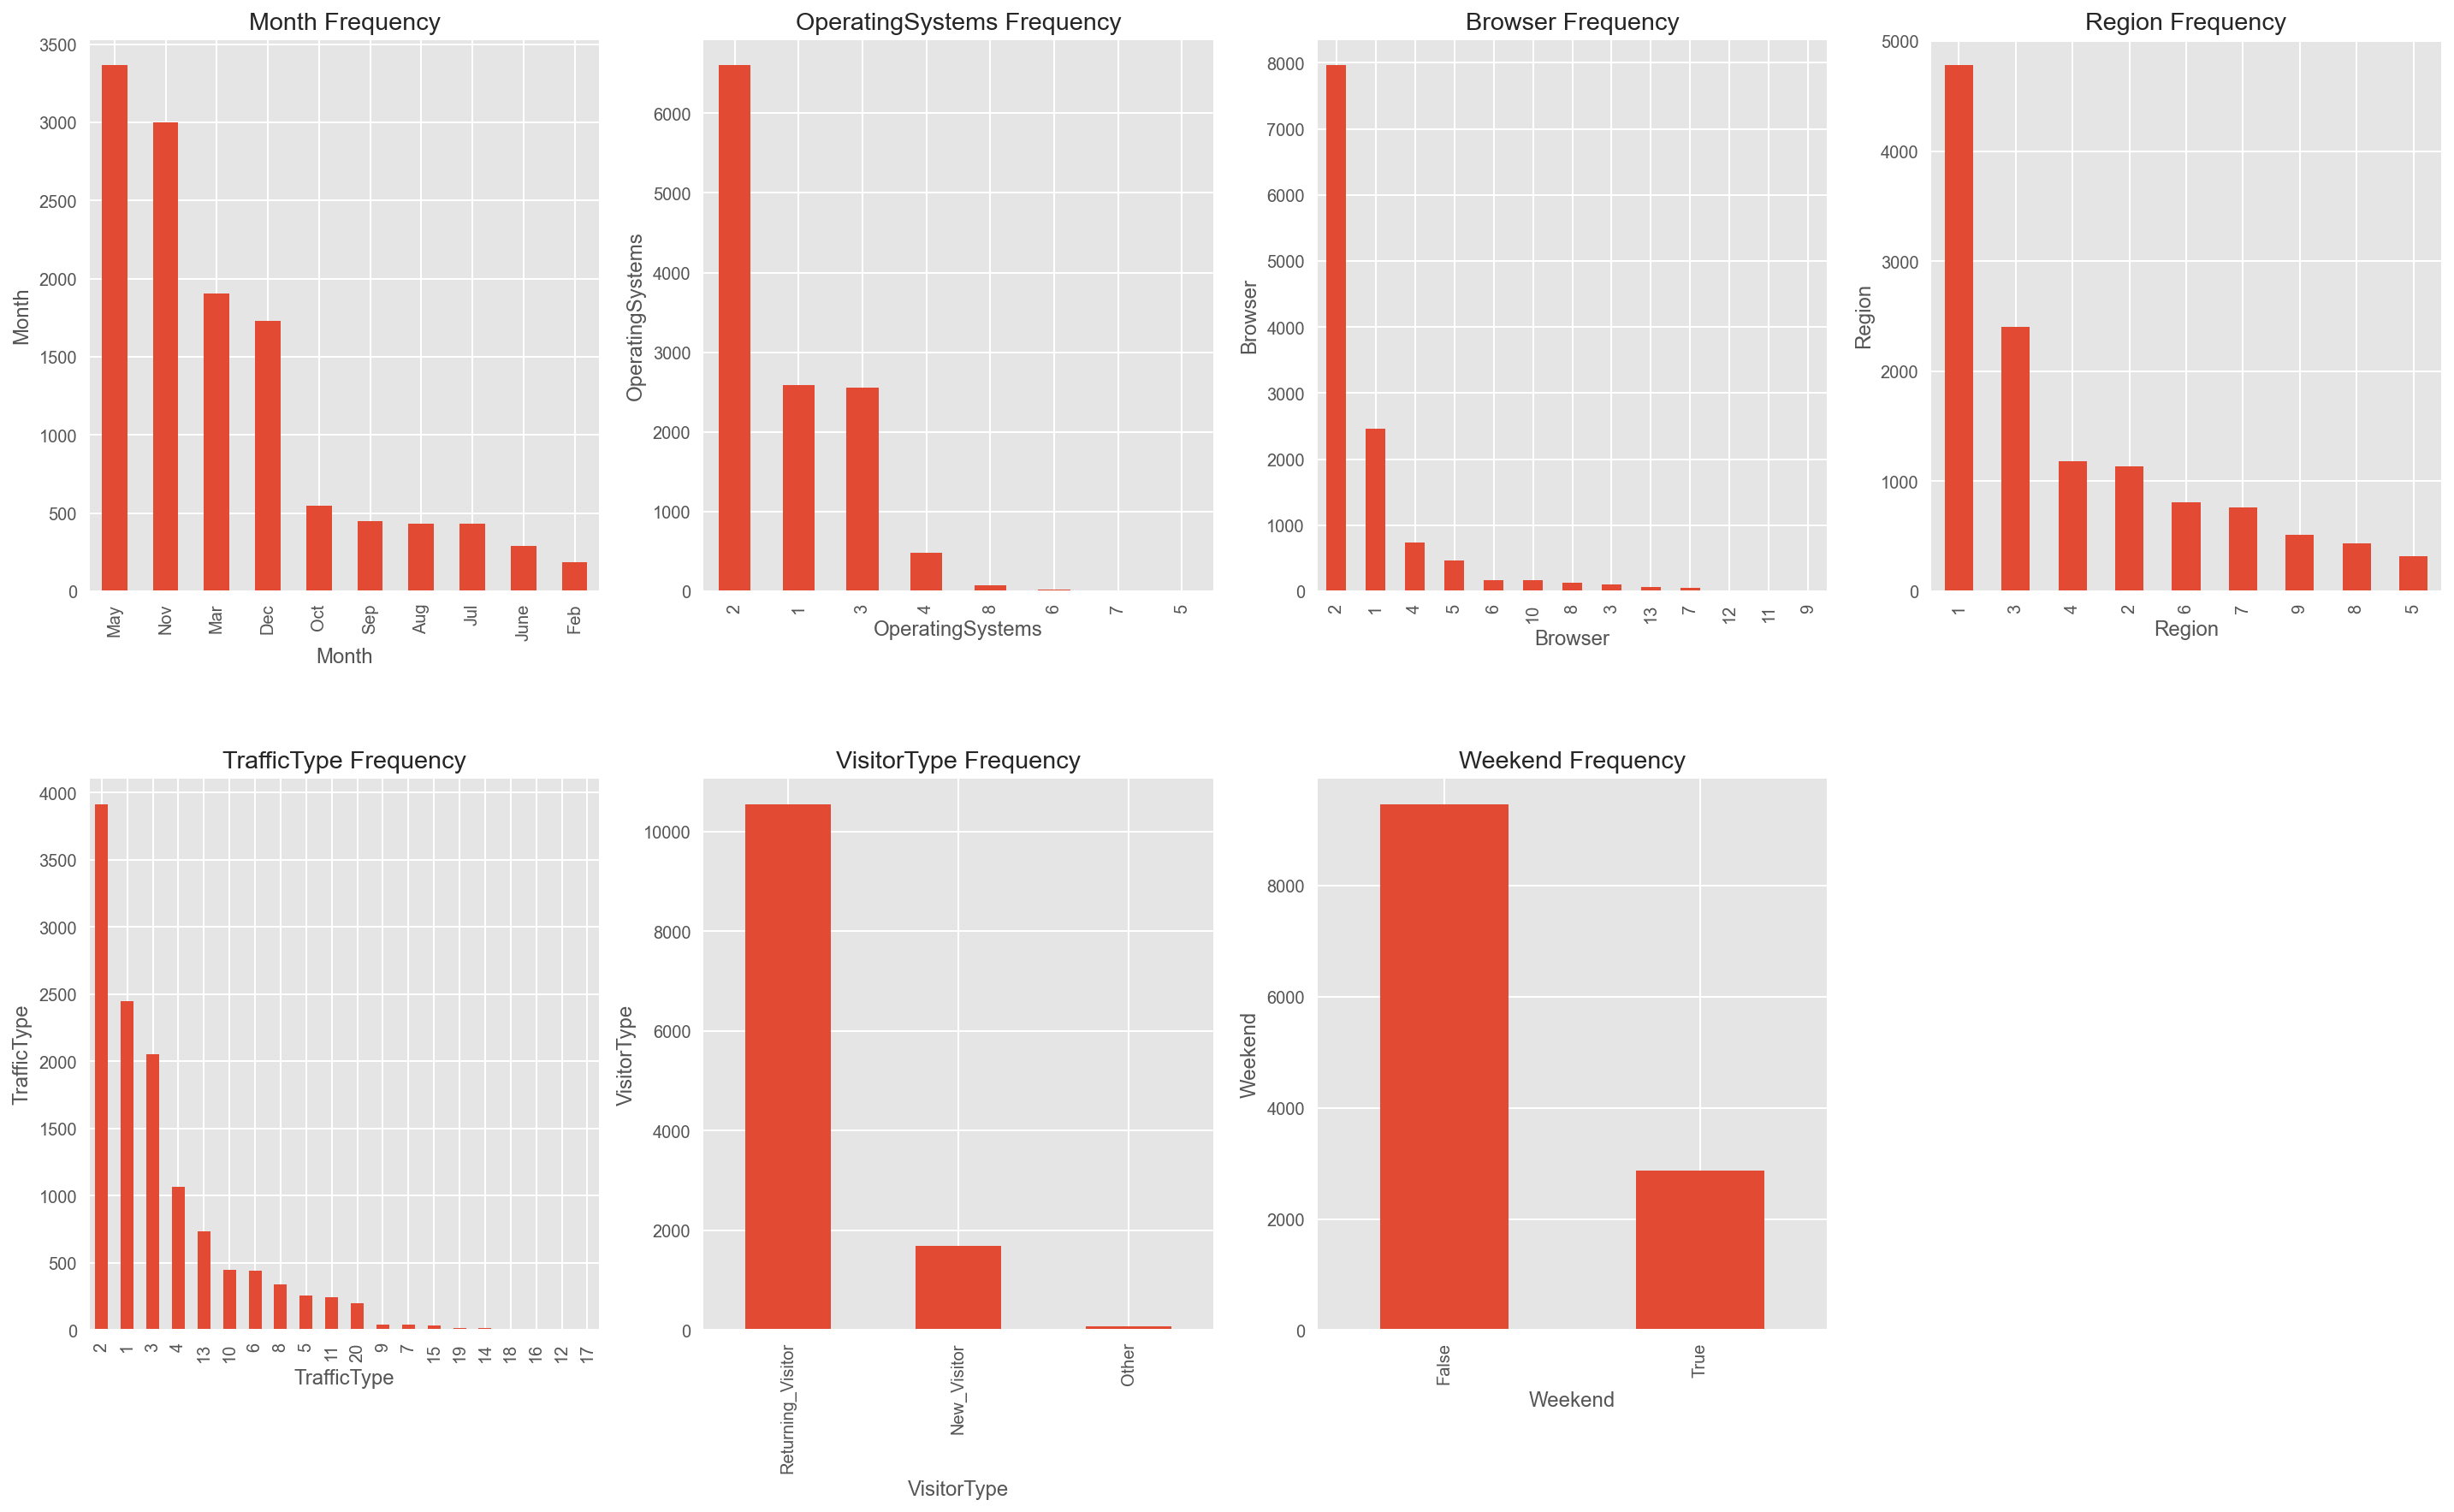

In [11]:
plt.figure(figsize = (20, 35))
for i, col in enumerate(df_cat):
    plt.subplot(6,4, i + 1)
    df[col].value_counts().plot(kind='bar')
    plt.tight_layout()
    plt.title(str(col) + ' Frequency')
    plt.xlabel(col)
    plt.ylabel(col)

- All the categorical data ar imbalanced.For "operatingssystems","browser","traffictype", the difference between the maximum value and the minimum value is extremely large. So I will combine sparse data as "other" for reducting the number of columns after I get dummy (or one hot coding) in data preparation.
- Month:In the attribute of month, the frequency of occurrence is highest in May, followed by November.
- Operating system:The highest operating system is 2.
- Browser:The highest browser is browswer2.
- Region:In this data, region 1 has the highest frequency, followed by region 3.
- Traffictype:Traffictype 2 has the highest frequency, followed by region1.
- Visitortype:The number of returning visitor is far more than new visitor and other.
- weekend:Web browsing mainly does not happen at weekend

# Pre-Clustering Data Preparation

  - Implement interaction features
  - MinMax Scale for numerical data
  - Get dummy categorical data

In [12]:
# Interaction Features
df_num['admin_rate'] = df_num['Administrative_Duration'] / df_num['Administrative']
df_num['informational_rate'] = df_num['Informational_Duration'] / df_num['Informational']
df_num['productrelated_rate'] = df_num['ProductRelated_Duration'] / df_num['ProductRelated']

In [13]:
df_num.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,NaN,NaN,27.750000
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,NaN,NaN,74.107143
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,9.375,41.0,24.156250
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,28.925,NaN,40.961458
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,60.000,15.0,25.775641


In [14]:
df_num.admin_rate.replace(np.nan,0, inplace=True)
df_num.informational_rate.replace(np.nan,0, inplace=True)
df_num.productrelated_rate.replace(np.nan,0, inplace=True)
df_num.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,0.000,0.0,27.750000
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,0.000,0.0,74.107143
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,9.375,41.0,24.156250
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,28.925,0.0,40.961458
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,60.000,15.0,25.775641


In [15]:
# Remove 	Administrative	Administrative_Duration	Informational	Informational_Duration	ProductRelated	ProductRelated_Duration
df_num = df_num.drop(columns=['Administrative_Duration', 'Administrative',
                 'Informational_Duration', 'Informational',
                 'ProductRelated_Duration', 'ProductRelated'])

In [16]:
df_num.head(1)

,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate
0,0.0,0.028571,53.474571,0.0,0.0,0.0,27.75


In [17]:
# Minmax standardization
minmax_scale= (df_num-df_num.min())/(df_num.max()-df_num.min())
df_num_scale= pd.DataFrame(minmax_scale)
df_num_scale

,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate
0,0.000000,0.142857,0.147816,0.0,0.000000,0.000000,0.019667
1,0.071429,0.238095,0.000000,0.0,0.000000,0.000000,0.052521
2,0.000000,0.087500,0.000000,0.0,0.005984,0.023060,0.017120
3,0.000000,0.060185,0.000000,0.0,0.018464,0.000000,0.029030
4,0.000000,0.019231,0.000000,0.0,0.038300,0.008436,0.018268
...,...,...,...,...,...,...,...
12325,0.000000,0.136364,0.000000,0.0,0.031491,0.000000,0.025912
12326,0.038462,0.269231,0.000000,0.0,0.005745,0.016592,0.035670
12327,0.050000,0.140067,0.000000,0.0,0.000000,0.000000,0.032380
12328,0.080586,0.243590,0.000000,1.0,0.000000,0.000000,0.026440


In [18]:
df_cat.Weekend.replace([False, True], [0, 1], inplace = True)
df_cat.Month.replace(['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec'], [1,2,3,4,5,6,7,8,9,10,11,12], inplace = True)

In [19]:
# Check how many labels in each categorical columns
for col in df_cat.columns:
    print(col,":",len(df_cat[col].unique()),' labels')

Month : 10  labels
OperatingSystems : 8  labels
Browser : 13  labels
Region : 9  labels
TrafficType : 20  labels
VisitorType : 3  labels
Weekend : 2  labels


In [20]:
# OperatingSystems 
os_counts = df_cat.OperatingSystems.value_counts().to_frame().reset_index()
os_counts
os_counts.columns = ['idx','counts']

total_counts = os_counts.counts.sum()
percentages = []
for c in os_counts.counts:
    percentages.append((c/total_counts) * 100)
os_counts['%'] = percentages
os_counts

,idx,counts,%
0,2,6601,53.536091
1,1,2585,20.965126
2,3,2555,20.721817
3,4,478,3.876723
4,8,79,0.640714
5,6,19,0.154096
6,7,7,0.056772
7,5,6,0.048662


According to the above results and EDA,I will combine the sparse data as the "other" type when the percentage is lower than 3%.

In [21]:
# Define function
def os(k, thre):
    return 1 if os_counts[os_counts.idx == k['OperatingSystems']]['counts'].values[0] < thre else 0
df_cat['other_os'] = df_cat.apply(lambda k: os(k, 80), axis=1)

In [22]:
# Double check if the combination is right
df_cat['other_os'].value_counts()

0    12219
1      111
Name: other_os, dtype: int64

In [23]:
# Browser
br_counts = df_cat.Browser.value_counts().to_frame().reset_index()
br_counts.columns = ['idx','counts']
total_counts =br_counts.counts.sum()
percentages = []
for c in br_counts.counts:
    percentages.append((c/total_counts) * 100)
br_counts['%'] = percentages
br_counts

,idx,counts,%
0,2,7961,64.566099
1,1,2462,19.967559
2,4,736,5.969181
3,5,467,3.787510
4,6,174,1.411192
5,10,163,1.321979
6,8,135,1.094891
7,3,105,0.851582
8,13,61,0.494728
9,7,49,0.397405


According to the above results and EDA,I will combine the sparse data as the "other" type when the percentage is lower than 3%.

In [24]:
def br(k, thre):
    return 1 if br_counts[br_counts.idx == k['Browser']]['counts'].values[0] < thre else 0
df_cat['other_br'] = df_cat.apply(lambda k: br(k, 175), axis=1)

In [25]:
# Double check if the combination is right
df_cat['other_br'].value_counts()

0    11626
1      704
Name: other_br, dtype: int64

In [26]:
# Region
reg = df_cat['Region'].value_counts().reset_index()
print(reg.index)
for index in reg.index:
    rate = df_cat[df_cat.Region == index].shape[0] / df_cat.Region.shape[0]*100
    print(index,": ",rate)

RangeIndex(start=0, stop=9, step=1)
0 :  0.0
1 :  38.767234387672346
2 :  9.213300892133008
3 :  19.48905109489051
4 :  9.586374695863748
5 :  2.579075425790754
6 :  6.528791565287915
7 :  6.171938361719383
8 :  3.5198702351987023


In [27]:
# TrafficType
tr_counts = df_cat.TrafficType.value_counts().to_frame().reset_index()
tr_counts.columns = ['idx','counts']
total_counts =tr_counts.counts.sum()
percentages = []
for c in tr_counts.counts:
    percentages.append((c/total_counts) * 100)
tr_counts['%'] = percentages
tr_counts

,idx,counts,%
0,2,3913,31.735604
1,1,2451,19.878345
2,3,2052,16.642336
3,4,1069,8.669911
4,13,738,5.985401
5,10,450,3.649635
6,6,444,3.600973
7,8,343,2.781833
8,5,260,2.108678
9,11,247,2.003244


According to the above results and EDA,I will combine the sparse data as the "other" type when the percentage is lower than 3%.

In [28]:
def tr(k, thre):
    return 1 if tr_counts[tr_counts.idx == k['TrafficType']]['counts'].values[0] < thre else 0
df_cat['other_tr'] = df_cat.apply(lambda k: tr(k, 344), axis=1)

In [29]:
# Double check
df_cat['other_tr'].value_counts()

0    11117
1     1213
Name: other_tr, dtype: int64

In [30]:
df_cat_dummy = pd.get_dummies(df_cat, columns=['OperatingSystems','Browser','Region','TrafficType', 'VisitorType','Month','Weekend'])

In [31]:
df_cat_dummy.head(1)

,other_os,other_br,other_tr,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekend_0,Weekend_1
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [32]:
# After combining the sparse data, drop the columns with duplicated info.
df_cat_dummy = df_cat_dummy.drop(columns=['OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
                 'Browser_6','Browser_10','Browser_8','Browser_3','Browser_13','Browser_7','Browser_12','Browser_11','Browser_9',
                 'TrafficType_8', 'TrafficType_5', 'TrafficType_11','TrafficType_20', 'TrafficType_9', 'TrafficType_7', 'TrafficType_15', 'TrafficType_19',
                 'TrafficType_14', 'TrafficType_18', 'TrafficType_16', 'TrafficType_12', 'TrafficType_17'])

In [33]:
df_cat_dummy.shape

(12330, 42)

In [34]:
# Display all the columns
pd.options.display.max_columns = 60
df_updated = pd.concat([df_num_scale, df_cat_dummy],axis=1)
df_updated.head()

,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate,other_os,other_br,other_tr,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,Browser_1,Browser_2,Browser_4,Browser_5,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_6,TrafficType_10,TrafficType_13,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_2,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekend_0,Weekend_1
0,0.000000,0.142857,0.147816,0.0,0.000000,0.000000,0.019667,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0.071429,0.238095,0.000000,0.0,0.000000,0.000000,0.052521,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,0.000000,0.087500,0.000000,0.0,0.005984,0.023060,0.017120,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.000000,0.060185,0.000000,0.0,0.018464,0.000000,0.029030,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
4,0.000000,0.019231,0.000000,0.0,0.038300,0.008436,0.018268,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


# Cluster Modeling

In this part, I will explain and present hierarchical and K-means clustering work,and interpret the outputs of the models (comment on the Dendrogram + elbow + silhouette plots). The below code reference is from https://github.com/mattharrison/ml_pocket_reference/blob/master/ch18.ipynb .

### Hierarchical clustering algorithm
- An algorithm that groups similar objects into groups called clusters.If two clusters are merged, the dendrogram will join them in a graph and the height of the join will be the distance between those clusters. 
Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps: (1) identify the two clusters that are closest together, and (2) merge the two most similar clusters. This iterative process continues until all the clusters are merged together.

From the below output, I will choose 2 clusters as it is reasonable.

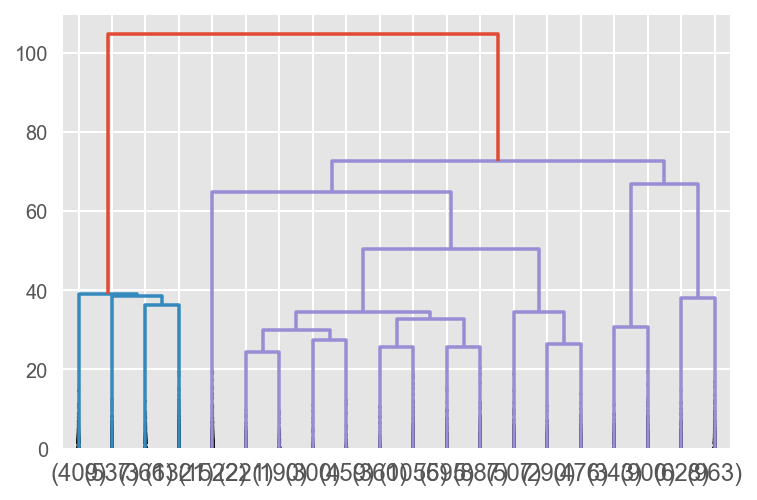

In [35]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6, 4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(df_updated, method="ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True,
)


###  Elbow Method
- The idea behind the elbow method is that the explained variation changes rapidly for a small number of clusters and then it slows down leading to an elbow formation in the curve. The elbow point is the number of clusters we can use for our clustering algorithm. From the below output, I will choose 3 clusters.

Text(0, 0.5, 'Inertia')

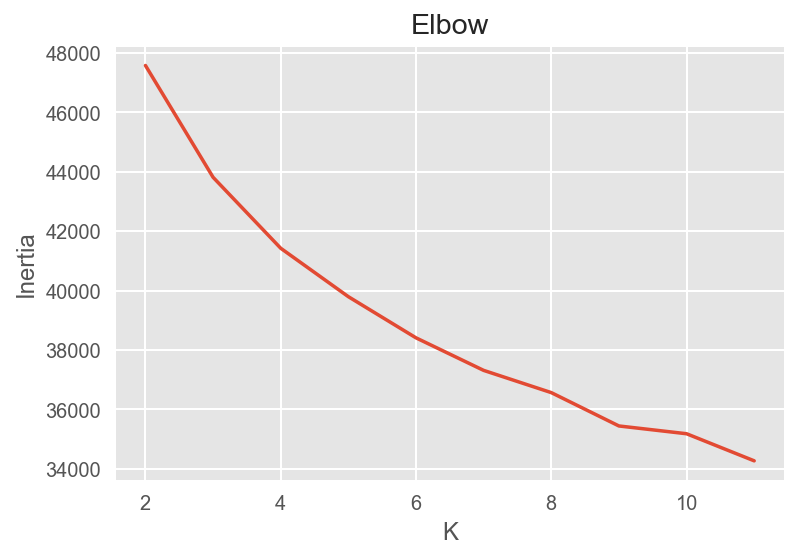

In [36]:
inertias = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(df_updated)
    inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(inertias, index=sizes).plot(ax=ax)
plt.title("Elbow")
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

### silhouette plots
- The Silhouette Coefficient tells us if individual points are correctly assigned to their clusters. We can use the following thumb rules while using Silhouette Coefficient:S(i) close to 0 means that the point is between two clusters
- If it is closer to -1, then we would be better off assigning it to the other clusters
- If S(i) is close to 1, then the point belongs to the ‘correct’ cluster
So I choose 2 clusters

array([[<AxesSubplot:xlabel='k'>]], dtype=object)

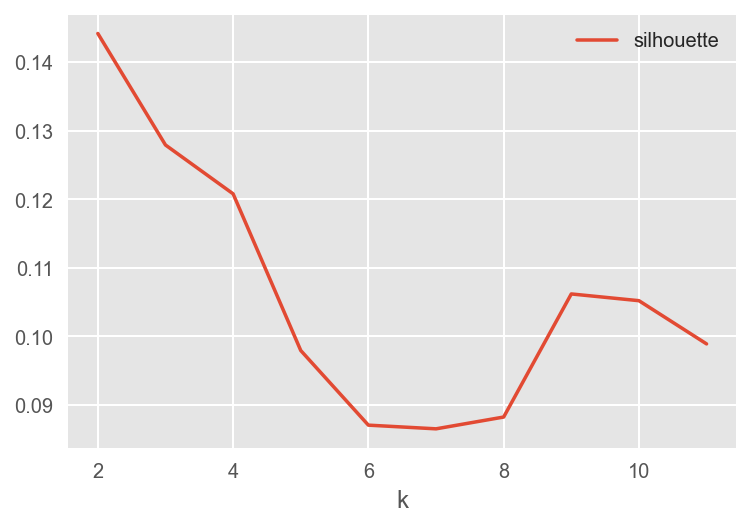

In [37]:
from sklearn import metrics
from sklearn.cluster import KMeans

sils = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(df_updated)
    
    sils.append(
        metrics.silhouette_score(df_updated, k2.labels_)
    )
fig, ax = plt.subplots(figsize=(6, 4))
(
    pd.DataFrame(
        {
            
            "silhouette": sils,
            
            "k": sizes,
        }
    )
    .set_index("k")
    .plot(ax=ax, subplots=True, layout=(1, 1))
)
#fig.savefig("images/mlpr_1802.png", dpi=300)

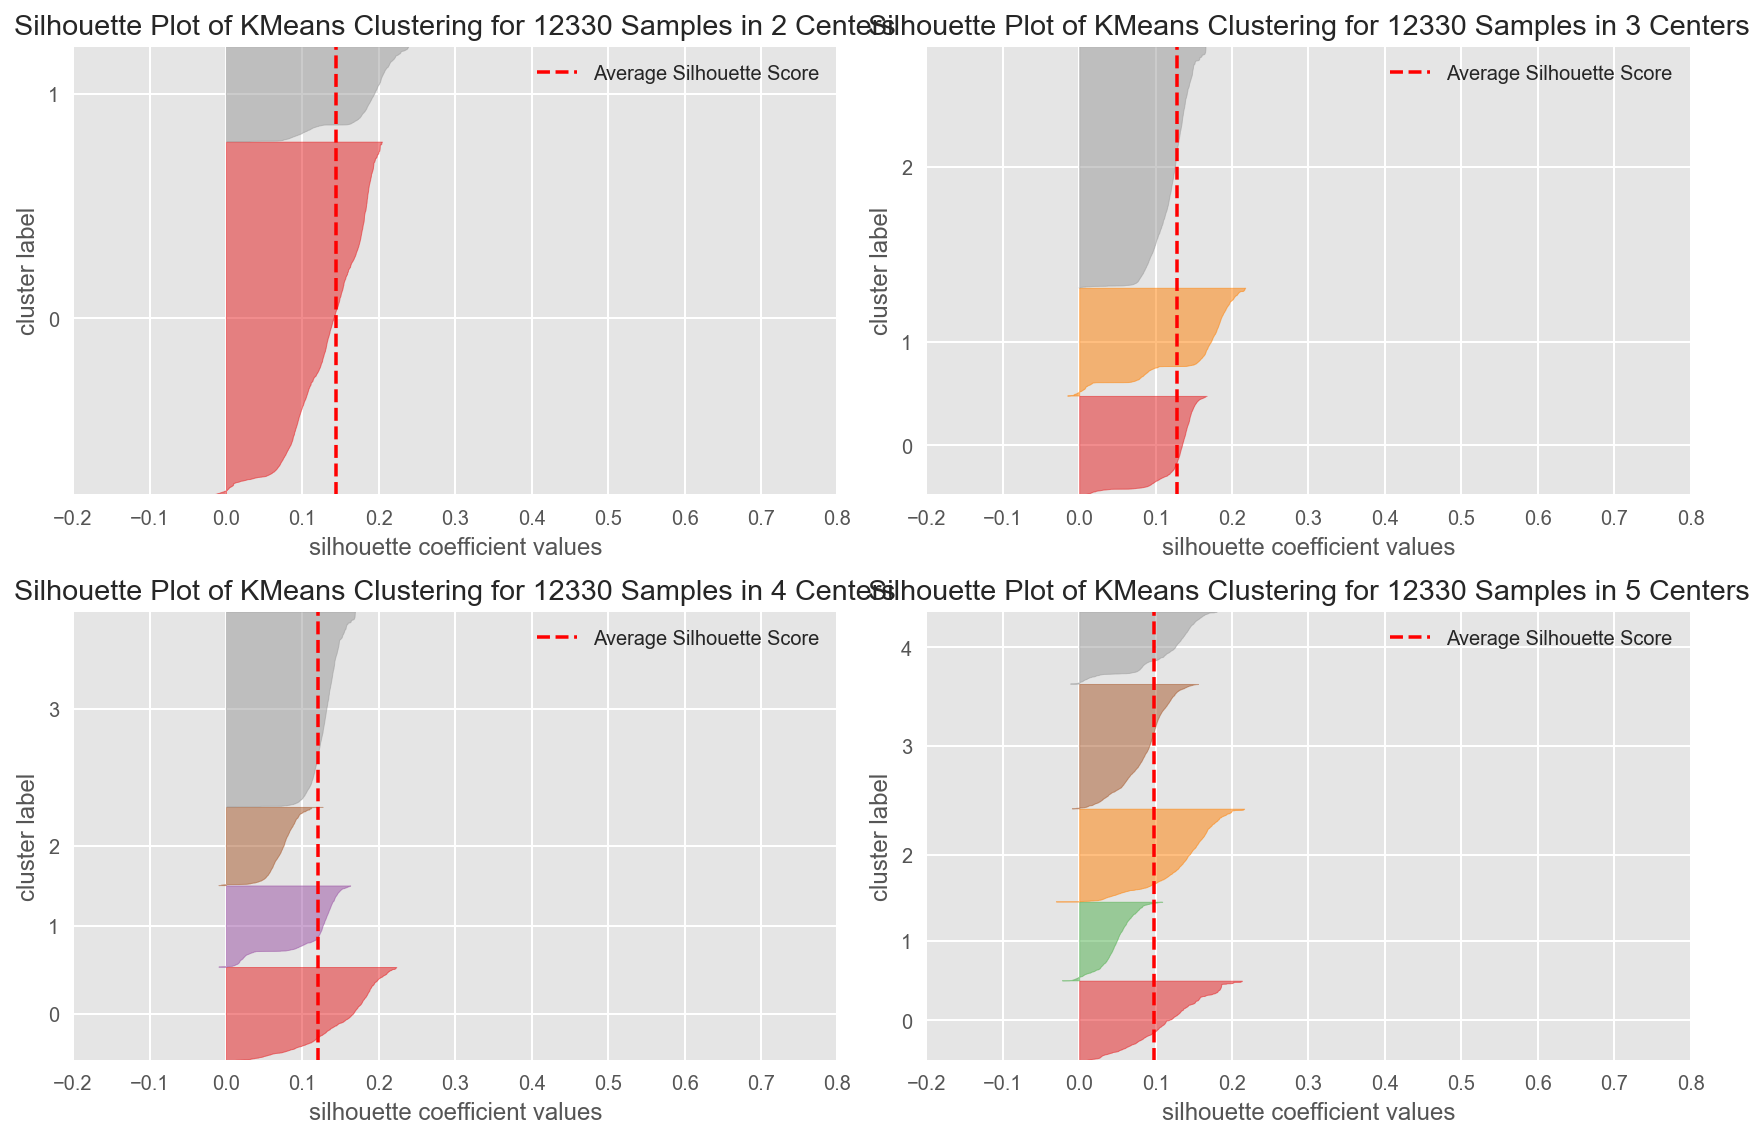

In [38]:
from yellowbrick.cluster.silhouette import (
    SilhouetteVisualizer,
)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.reshape(4)
for i, k in enumerate(range(2, 6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
        KMeans(n_clusters=k, random_state=42),
        ax=ax,
    )
    sil.fit(df_updated)
    sil.finalize()
    ax.set_xlim(-0.2, 0.8)
plt.tight_layout()

Here is the Silhouette analysis done on the above plots to select an optimal value for n_clusters.
- The value of n_clusters as 4 and 5 is not optimal for the given data due to the following reasons:
 - The presence of clusters with below-average silhouette scores.
 - The size fluctuations is wide.
- The value of 2 and 3 looks to be the optimal one. The reason is that each cluster is above average silhouette scores.
However, I think the 3 might be more good than 2 because the thickness is more uniform than the n_cluster as 2.



Combining the results of the above three methods, n-cluster is 2. So I will choose 2, which is consistent with the teacher's homework requirements.

### K-means clustering with 2 groups

In [39]:
X = df_updated
estimator = KMeans(n_clusters=2)
k2_fit = estimator.fit(X)
k2_fit


KMeans(n_clusters=2)

In [40]:
#  finding the center of the clusters:
centroids = k2_fit.cluster_centers_
centroids

array([[ 1.32415598e-01,  2.35578179e-01,  1.51539935e-02,
         5.19510329e-02,  1.32472411e-02,  6.47582427e-03,
         2.55220916e-02,  4.97322112e-03,  5.50879878e-02,
         1.11323642e-01,  8.81790360e-01,  5.73833206e-03,
         3.82555471e-04,  1.07115532e-01,  9.41469013e-01,
        -3.66373598e-15,  1.14766641e-03,  2.29533282e-03,
         4.19663351e-01,  8.33970926e-02,  2.09257842e-01,
         1.06732976e-01,  1.45371079e-02,  6.04437643e-02,
         3.82555471e-02,  3.94032135e-02,  2.83091048e-02,
         1.56847743e-01,  3.33970926e-01,  2.46748279e-01,
         8.95179801e-02,  1.72149962e-02,  4.32287682e-02,
         1.14766641e-03,  1.55700077e-01,  2.29533282e-03,
         8.42004591e-01,  2.60137720e-02,  1.46518745e-01,
         2.45983168e-01,  2.21882173e-02,  3.44299923e-02,
         3.63427697e-02,  2.98393267e-02,  5.81484315e-02,
         2.52486611e-01,  1.48048967e-01,  7.12318286e-01,
         2.87681714e-01],
       [ 1.05183639e-01,  2.09

In [41]:
k2_fit.labels_

array([0, 1, 1, ..., 1, 1, 0])

In [42]:
df_updated['Revenue'] = k2_fit.labels_ 
df_updated.head()

,BounceRates,ExitRates,PageValues,SpecialDay,admin_rate,informational_rate,productrelated_rate,other_os,other_br,other_tr,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,Browser_1,Browser_2,Browser_4,Browser_5,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_6,TrafficType_10,TrafficType_13,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_2,Month_3,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekend_0,Weekend_1,Revenue
0,0.000000,0.142857,0.147816,0.0,0.000000,0.000000,0.019667,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0.071429,0.238095,0.000000,0.0,0.000000,0.000000,0.052521,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0.000000,0.087500,0.000000,0.0,0.005984,0.023060,0.017120,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
3,0.000000,0.060185,0.000000,0.0,0.018464,0.000000,0.029030,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.000000,0.019231,0.000000,0.0,0.038300,0.008436,0.018268,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1


# Post-Clustering Exploratory Data Analysis

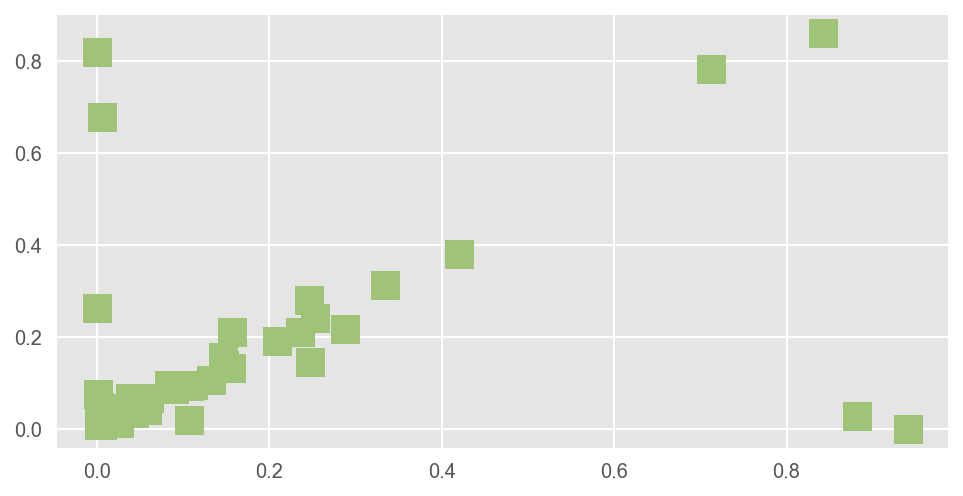

In [43]:
# Make cluster plot
plt.scatter(centroids[0],centroids[1], s=200, c='g', marker='s')
plt.show()

From the above output, I can noticeably identify the two groupings ranging from 0.0-0.2(x-axis and y-axis) and 0.2-0.4 (x-axis and y-axis), respectively. 

Text(0, 0.5, 'Counts')

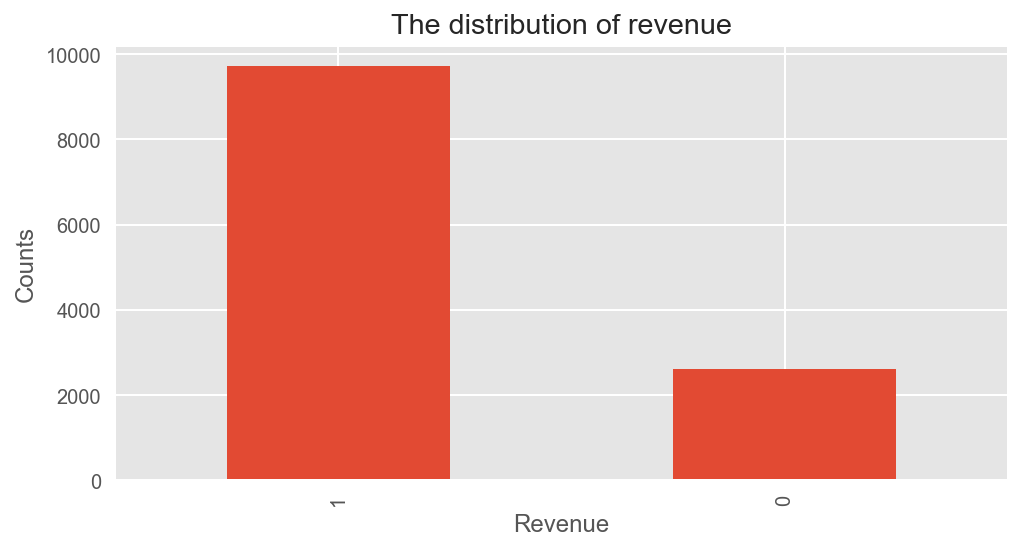

In [44]:
# Make barplot for revenue.
df_updated.Revenue.value_counts().plot(kind='bar')
plt.title("The distribution of revenue")
plt.xlabel("Revenue")
plt.ylabel("Counts")

From the above output, we can see the classes are not balanced. The number of people who made the purchase is far more than those who did not purchase.

# Clustering Output vs. Actual Labels

Compare the content of V_Revenue to the content of the Revenue column generated by your clustering algorithm.

In [45]:
#loading the data labels
df_label = pd.read_csv("https://raw.githubusercontent.com/sczhou0705/DAV-6150-2/main/Project2_Data_Labels.csv")
#sanity check
df_updated['V_Revenue'] = df_label.Revenue
df_updated.V_Revenue.replace([False, True], [1, 0], inplace = True)

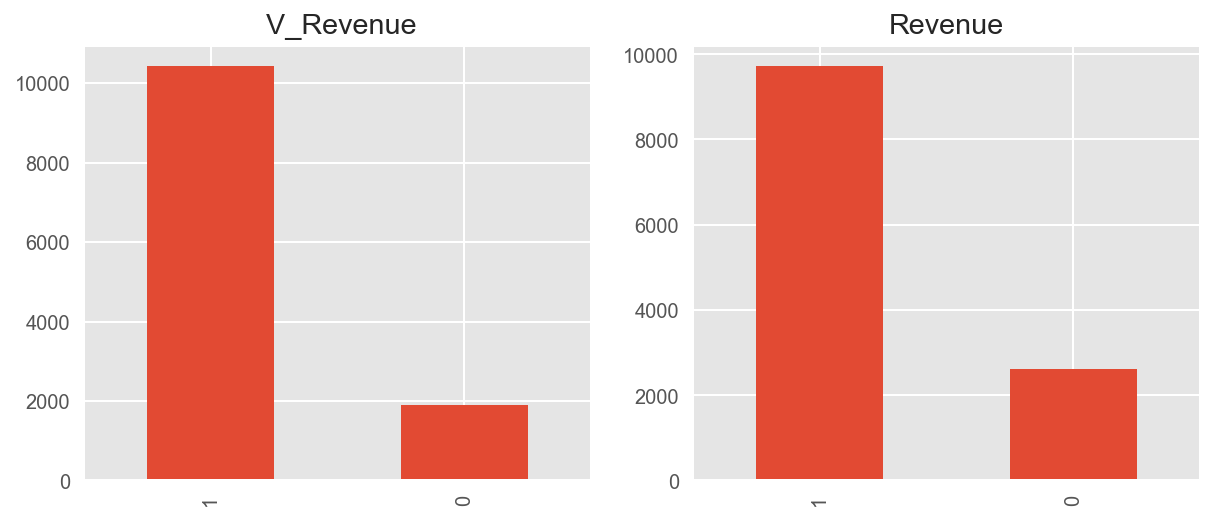

In [46]:
# Make two barplot to compare the V_revenue and predicted revenue
plt.figure(figsize=(10,4))
# Create the first barplot
plt.subplot(1,2,1)
df_updated['V_Revenue'].value_counts().plot(kind='bar');
plt.title(' V_Revenue')
# Create the second barplot
plt.subplot(1,2,2)
df_updated['Revenue'].value_counts().plot(kind='bar');
plt.title('Revenue')
plt.show();

In [47]:
df_com = df_updated.copy()
# Compare the result
df_com['comparison'] = np.where(df_com['Revenue'] == df_com['V_Revenue'],'no_difference','has_difference')

In [48]:
print(df_com['comparison'].value_counts())
print('---')
print('accuracy: ' , df_com['comparison'].value_counts()[0] / df_com['comparison'].shape[0])

no_difference     8584
has_difference    3746
Name: comparison, dtype: int64
---
accuracy:  0.6961881589618816


- Similarities:The output of the clustering algorithm indicate the number of web site visitors made a purchase more than those not made a purchase.
- Difference: In 12330 observations of revenue, the values of 8584 ovbservatons are equal to the values of V_revenue. The accuracy is 69.6%.

# SVM Modeling

- feature selection and domain knowledge 
- SVM model 1
- SVM model 2
- SVM model 3

(I referenced part of the code from my previous assignment 8  https://yu.instructure.com/courses/50398/assignments/191959 ) 

In [49]:
# Select features for categorical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df_updated.iloc[:,7:49]
y = df_updated['Revenue']
print("Feature data dimension: ", X.shape)
print("----")
select = SelectKBest(score_func=chi2, k=42)
fit = select.fit(X,y)
# type(fit)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([columns,scores],axis=1)
featureScores.columns = ['Features','Score'] 
# Print 42 best features
print(featureScores.nlargest(42,'Score'))
print('------')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# Apply SelectKBest class to extract top 7 best features
bestfeatures = SelectKBest(score_func=f_regression, k=7)
X = df_updated.iloc[:,0:7]
y = df_updated['Revenue']
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# Naming the dataframe columns
featureScores.columns = ['Features','Score'] 
# Print 7 best features
print(featureScores.nlargest(7,'Score'))

Feature data dimension:  (12330, 42)
----
                         Features        Score
7                       Browser_1  9141.598453
3              OperatingSystems_1  7148.287419
8                       Browser_2  2141.833471
4              OperatingSystems_2  1738.070853
5              OperatingSystems_3   684.863397
6              OperatingSystems_4   399.734593
26                 TrafficType_13   191.010834
9                       Browser_4   190.472951
22                  TrafficType_3   128.607852
10                      Browser_5   110.874988
41                      Weekend_1    43.263959
24                  TrafficType_6    32.541212
17                       Region_7    29.590862
20                  TrafficType_1    29.347355
30                        Month_2    27.343475
15                       Region_5    16.289346
37                       Month_10    13.826428
19                       Region_9    13.808685
40                      Weekend_0    13.113616
28              Vi

__Feature selection explanation__: 
Numerical data: Based on the above output and domain knowledge, we know bounce rates and exit rates are the main google analytics metrics to measure page quality. I will select the first two attributes. Also I will include informational_rate attribute in model 3 for further prediction.
Categorical data: With EDA explanation, I will choose month_5, region 1 as features. Because they have the highest frequency in the data set. For other attributes, I will select an attribute for each type according to the highest score of the chi2 square test.

In [50]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   BounceRates                    12330 non-null  float64
 1   ExitRates                      12330 non-null  float64
 2   PageValues                     12330 non-null  float64
 3   SpecialDay                     12330 non-null  float64
 4   admin_rate                     12330 non-null  float64
 5   informational_rate             12330 non-null  float64
 6   productrelated_rate            12330 non-null  float64
 7   other_os                       12330 non-null  int64  
 8   other_br                       12330 non-null  int64  
 9   other_tr                       12330 non-null  int64  
 10  OperatingSystems_1             12330 non-null  uint8  
 11  OperatingSystems_2             12330 non-null  uint8  
 12  OperatingSystems_3             12330 non-null 

In [51]:
# The features of the model BounceRates	ExitRates	OperatingSystems_1	Browser_1	VisitorType_New_Visitor	Weekend_1
df_updated_model1 = df_updated.iloc[:,[0,1,10,14,34,48]]
df_updated_model1

,BounceRates,ExitRates,OperatingSystems_1,Browser_1,VisitorType_New_Visitor,Weekend_1
0,0.000000,0.142857,1,1,1,1
1,0.071429,0.238095,0,0,0,0
2,0.000000,0.087500,0,0,1,0
3,0.000000,0.060185,1,1,0,0
4,0.000000,0.019231,0,0,0,0
...,...,...,...,...,...,...
12325,0.000000,0.136364,0,0,0,1
12326,0.038462,0.269231,0,0,0,0
12327,0.050000,0.140067,0,0,0,0
12328,0.080586,0.243590,0,0,0,1


In [52]:
df_updated_model2 = df_updated.iloc[:,[0,1,18,33,39]]
df_updated_model2

,BounceRates,ExitRates,Region_1,TrafficType_13,Month_5
0,0.000000,0.142857,1,0,1
1,0.071429,0.238095,0,0,0
2,0.000000,0.087500,0,0,0
3,0.000000,0.060185,0,0,0
4,0.000000,0.019231,0,0,1
...,...,...,...,...,...
12325,0.000000,0.136364,1,0,0
12326,0.038462,0.269231,0,0,0
12327,0.050000,0.140067,1,1,0
12328,0.080586,0.243590,0,0,1


In [53]:
df_updated_model3 = df_updated.iloc[:,[0,1,5,10,14,34,48,18,33,39]]
df_updated_model3

,BounceRates,ExitRates,informational_rate,OperatingSystems_1,Browser_1,VisitorType_New_Visitor,Weekend_1,Region_1,TrafficType_13,Month_5
0,0.000000,0.142857,0.000000,1,1,1,1,1,0,1
1,0.071429,0.238095,0.000000,0,0,0,0,0,0,0
2,0.000000,0.087500,0.023060,0,0,1,0,0,0,0
3,0.000000,0.060185,0.000000,1,1,0,0,0,0,0
4,0.000000,0.019231,0.008436,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
12325,0.000000,0.136364,0.000000,0,0,0,1,1,0,0
12326,0.038462,0.269231,0.016592,0,0,0,0,0,0,0
12327,0.050000,0.140067,0.000000,0,0,0,0,1,1,0
12328,0.080586,0.243590,0.000000,0,0,0,1,0,0,1


In [54]:
# Load packages
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


In [55]:
# SVM model 1
X = df_updated_model1
y = df_updated['Revenue']
# Creating train and testing set
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# Use the kernel='rbf'
model1_rbf=svm.SVC(C=1,kernel='rbf',decision_function_shape='ovo') 
model1_rbf.fit(X1_train,y1_train.ravel())
# Cross validation.
accuracy = cross_val_score(model1_rbf, X1_train, y1_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(model1_rbf, X1_train, y1_train, scoring = "recall", cv = 10)
auc = cross_val_score(model1_rbf, X1_train, y1_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(model1_rbf, X1_train, y1_train, scoring = "f1", cv = 10)
precision = cross_val_score(model1_rbf, X1_train, y1_train, scoring = "precision", cv = 10)

model1_summary_svm = [accuracy.mean(),recall.mean(),auc.mean(),f1.mean(),precision.mean()]
model1_summary_svm = pd.DataFrame(model1_summary_svm,columns=['SVM_Model1'],index=['accuracy','recall','auc','f1','precision'])
model1_summary_svm

,SVM_Model1
accuracy,0.987632
recall,0.998451
auc,0.998116
f1,0.992180
precision,0.985996


In [56]:
# SVM model 2
X = df_updated_model2
y = df_updated['Revenue']
# Creating train and testing set
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# Use the kernel='rbf'
model2_rbf=svm.SVC(C=1,kernel='rbf',decision_function_shape='ovo') 
model2_rbf.fit(X2_train,y2_train.ravel())
# Cross validation.
accuracy = cross_val_score(model2_rbf, X2_train, y2_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(model2_rbf, X2_train, y2_train, scoring = "recall", cv = 10)
auc = cross_val_score(model2_rbf, X2_train, y2_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(model2_rbf, X2_train, y2_train, scoring = "f1", cv = 10)
precision = cross_val_score(model2_rbf, X2_train, y2_train, scoring = "precision", cv = 10)

model2_summary_svm = [accuracy.mean(),recall.mean(),auc.mean(),f1.mean(),precision.mean()]
model2_summary_svm = pd.DataFrame(model2_summary_svm,columns=['SVM_Model2'],index=['accuracy','recall','auc','f1','precision'])
model2_summary_svm

,SVM_Model2
accuracy,0.785483
recall,1.000000
auc,0.526201
f1,0.879855
precision,0.785483


In [57]:
# SVM model 3
X = df_updated_model3
y = df_updated['Revenue']
# Creating train and testing set
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y,test_size = 0.2, random_state = 0)
# Use the kernel='rbf'
model3_rbf=svm.SVC(C=1,kernel='rbf',decision_function_shape='ovo') 
model3_rbf.fit(X3_train,y3_train.ravel())
# Cross validation.
accuracy = cross_val_score(model3_rbf, X3_train, y3_train, scoring = "accuracy", cv = 10)
recall = cross_val_score(model3_rbf, X3_train, y3_train, scoring = "recall", cv = 10)
auc = cross_val_score(model3_rbf, X3_train, y3_train, scoring = "roc_auc", cv = 10)
f1 = cross_val_score(model3_rbf, X3_train, y3_train, scoring = "f1", cv = 10)
precision = cross_val_score(model3_rbf, X3_train, y3_train, scoring = "precision", cv = 10)

model3_summary_svm = [accuracy.mean(),recall.mean(),auc.mean(),f1.mean(),precision.mean()]
model3_summary_svm = pd.DataFrame(model3_summary_svm,columns=['SVM_Model3'],index=['accuracy','recall','auc','f1','precision'])
model3_summary_svm

,SVM_Model3
accuracy,0.986923
recall,0.997806
auc,0.997848
f1,0.991728
precision,0.985732


# Select model

In [58]:
# Create table
all_svm_models = pd.concat([model1_summary_svm, model2_summary_svm,model3_summary_svm],axis=1)
all_svm_models

,SVM_Model1,SVM_Model2,SVM_Model3
accuracy,0.987632,0.785483,0.986923
recall,0.998451,1.000000,0.997806
auc,0.998116,0.526201,0.997848
f1,0.992180,0.879855,0.991728
precision,0.985996,0.785483,0.985732


I select SVM_Model3 as my prefered model.

__SVM_Model1& SVM_Model3 vs SVM_Model2__:
Firstly, the dataset is imbalanced, I can not choose the model only by the result of accuracy. Compared with model 1&3,the auc of SVM_Model2 only have 0.52,far less than model1 and model2 even if the model has high recall and f1 score.

__SVM_Model1 vs SVM_Model3__:
The attributes in model 1 are inclusive in model3.Their scores are very close to each other. Although model 1 is slightly higher than model 3, I still like model 3 because model 3 involves more comprehensive attributes.

# Clustering + SVM Output vs. Actual Labels

In [59]:
# Use model 3 to test the data.
test_Y_pred = model3_rbf.predict(X3_test)

y_pred = pd.DataFrame(test_Y_pred, columns = ['Revenue'])
# Check the y_pred size
print(y_pred.shape)

(2466, 1)


In [60]:
print("Accuracy of svm on test set: ",model3_rbf.score(X3_test,y3_test))
print("Testing MSE:", mean_squared_error(y3_test, test_Y_pred))
print("Testing RMSE:", np.sqrt(mean_squared_error(y3_test, test_Y_pred)))
print('----------------------------------------')
print(confusion_matrix(y3_test, test_Y_pred))
print('----------------------------------------')
print(classification_report(y3_test, test_Y_pred))

Accuracy of svm on test set:  0.98661800486618
Testing MSE: 0.01338199513381995
Testing RMSE: 0.11568057370976317
----------------------------------------
[[ 468   30]
 [   3 1965]]
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       498
           1       0.98      1.00      0.99      1968

    accuracy                           0.99      2466
   macro avg       0.99      0.97      0.98      2466
weighted avg       0.99      0.99      0.99      2466



The test set output is close to the train set as we expected.

In [61]:
# SVM model 3
X = df_updated_model3
y = df_updated['V_Revenue']
# Creating train and testing set
print(y.shape)
X1v_train, X1v_test, y1v_train, y1v_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(y1v_test.shape)
V_revenue = df_updated.iloc[y1v_test,:]["V_Revenue"]
V_revenue = pd.DataFrame(V_revenue, columns = ['V_Revenue'])

(12330,)
(2466,)


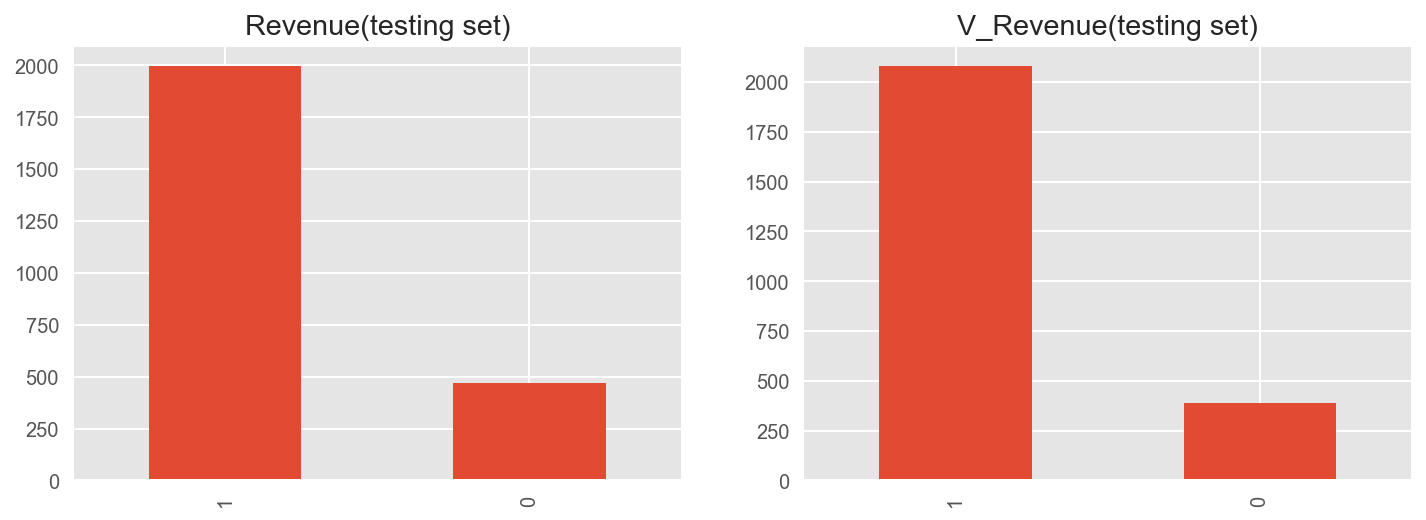

1    1995
0     471
Name: Revenue, dtype: int64
1    2078
0     388
Name: V_Revenue, dtype: int64


In [62]:
# Create figsize 
plt.figure(figsize=(12,4))
# Create the first bar plot
plt.subplot(1,2,1)
y_pred['Revenue'].value_counts().plot(kind='bar');
plt.title('Revenue(testing set)')
# Create the second bar plot
plt.subplot(1,2,2)
V_revenue['V_Revenue'].value_counts().plot(kind='bar');
plt.title('V_Revenue(testing set)')
plt.show();


print(y_pred['Revenue'].value_counts())
print(V_revenue['V_Revenue'].value_counts())


In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html 
# Accuracy classification score:the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
print(metrics.accuracy_score(y_pred,V_revenue))
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print(metrics.precision_score(y_pred,V_revenue))
# The recall is intuitively the ability of the classifier to find all the positive samples.
print(metrics.recall_score(y_pred,V_revenue))
# F1 = 2 * (precision * recall) / (precision + recall)
print(metrics.f1_score(y_pred,V_revenue))

0.7165450121654501
0.8118383060635226
0.8456140350877193
0.8283820279891971


There is a real deviation between actualrevenue and forecasted revenue. The accuracy rate is only 72%. High precision relates to the low false positive rate. I have got 0.811 precision which is pretty good.The recall answers is: of all the buyers that truly purchased.I have got recall of 0.84 which is good for this model as it’s above 0.5. F1 is usually more useful than accuracy, especially I have an uneven class distribution. I have got f1 of 0.82 for this model 

# Conclusion

- Bounce rate and exict rate are very important metrics for google analysis, and we cannot ignore them. 
- I used three methods to select the best cluster, and the final result was 2, which is consistent with the teacher's homework requirements.
- Construct three different SVM models using different explanatory variables. I choose the model 3 because it has higher scores than model 2 and have comprehensive features than model1.
- I used model 3 to predict and test the revenue. Also, I got the F1 scores over 80% after compared revenue with v_revenue. The results of the combined clustering and svm modeling process are well aligned with the actual v_revenue data values.

# Reference:
- https://github.com/mattharrison/ml_pocket_reference/blob/master/ch18.ipynb
- https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html